In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

from keras import models
from keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint





Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
train_size, test_size = 480, 125
img_width, img_height = 224, 224  # Default input size for VGG
batch_size = 32
epochs = 100

# Instantiate convolutional base

conv_base = VGG16(weights='imagenet', 
                  include_top=False)

# Freeze the layers except the last 4 layers
for layer in conv_base.layers[:-4]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)    
    
#Create your own input format 
inp = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = conv_base(inp)

#Add the fully-connected layers
x = models.Sequential()
x = Flatten(name='flatten', input_shape=(7,7,512))(output_vgg16_conv)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

my_model = Model(input=inp, output=x)
my_model.summary()

<keras.engine.input_layer.InputLayer object at 0x7fce22104710> False
<keras.layers.convolutional.Conv2D object at 0x7fce22104a90> False
<keras.layers.convolutional.Conv2D object at 0x7fce22104908> False
<keras.layers.pooling.MaxPooling2D object at 0x7fce22101a90> False
<keras.layers.convolutional.Conv2D object at 0x7fce22101d30> False
<keras.layers.convolutional.Conv2D object at 0x7fce220b59e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fce220c9e10> False
<keras.layers.convolutional.Conv2D object at 0x7fce220c9b38> False
<keras.layers.convolutional.Conv2D object at 0x7fce22078cc0> False
<keras.layers.convolutional.Conv2D object at 0x7fce22011e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fce2203ecc0> False
<keras.layers.convolutional.Conv2D object at 0x7fce2203e780> False
<keras.layers.convolutional.Conv2D object at 0x7fce21fea7f0> False
<keras.layers.convolutional.Conv2D object at 0x7fce22004b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7fce21fb07b8>

In [0]:
my_model.compile(optimizer=optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='train copy',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 480 images belonging to 6 classes.


In [0]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    directory='test copy',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 125 images belonging to 6 classes.


In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = my_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[es,
                              ModelCheckpoint('best.h5',
                              save_best_only=True)],
                    epochs=200
)

Epoch 1/200
15/15 [==============================] - 6s 426ms/step - loss: 3.7664e-05 - acc: 1.0000 - val_loss: 0.9388 - val_acc: 0.9032
Epoch 2/200
15/15 [==============================] - 6s 410ms/step - loss: 8.5541e-05 - acc: 1.0000 - val_loss: 1.1280 - val_acc: 0.8710
Epoch 3/200
15/15 [==============================] - 6s 409ms/step - loss: 6.1244e-05 - acc: 1.0000 - val_loss: 1.1770 - val_acc: 0.8750
Epoch 4/200
15/15 [==============================] - 6s 407ms/step - loss: 9.2704e-05 - acc: 1.0000 - val_loss: 1.2582 - val_acc: 0.8602
Epoch 5/200
15/15 [==============================] - 6s 408ms/step - loss: 3.8850e-04 - acc: 1.0000 - val_loss: 0.8482 - val_acc: 0.9355
Epoch 6/200
15/15 [==============================] - 6s 404ms/step - loss: 1.2010e-04 - acc: 1.0000 - val_loss: 1.1005 - val_acc: 0.8925
Epoch 7/200
15/15 [==============================] - 6s 406ms/step - loss: 1.0698e-04 - acc: 1.0000 - val_loss: 1.0318 - val_acc: 0.8958
Epoch 8/200
15/15 [======================

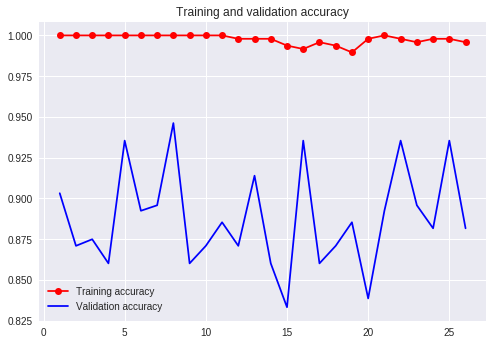

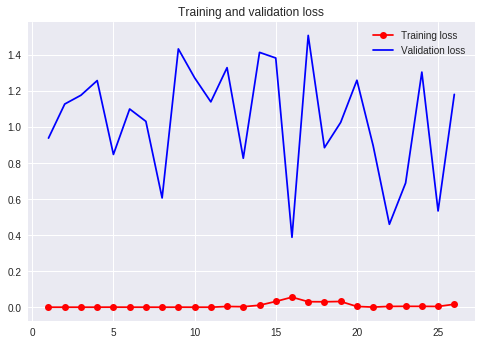

In [0]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'ro-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def predict_images(img):
  
  
  
    # load an image from file
    image = load_img(img, target_size=(224, 224))
    
    # convert the image pixels to a numpy array
    x = img_to_array(image)

    # convert the image pixels to a numpy array
    x = img_to_array(x)

    # reshape data for the model
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    # prepare the image for the VGG model
    x = preprocess_input(x)
    
    yhat = model.predict(x)
    y_classes = yhat.argmax(axis=-1)
    
    plt.imshow(image)
    return y_classes
  



0 = anger, 1 = disgust, 2 = fear, 3 = happy, 4 = neutral, 5 = surprise